In [3]:
import skimage.io as io
import os

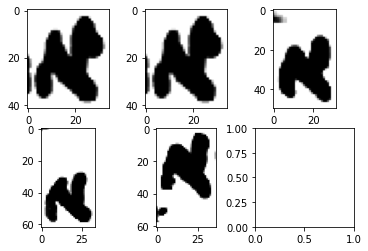

In [25]:
data_dir = "../../monkbrill"
styles = ["Archaic", "Hasmonean", "Herodian"]

letters = ['Alef', 'Bet', 'Gimel', 'Dalet', 'He', 'Waw', 'Zayin', 'Het', 
                   'Tet', 'Yod', 'Kaf', 'Kaf-final', 'Lamed',  'Mem-medial', 'Mem',
                   'Nun-medial', 'Nun-final', 'Samekh', 'Ayin', 'Pe', 'Pe-final',
                   'Tsadi-medial', 'Tsadi-final', 'Qof', 'Resh', 'Shin', 'Taw']


pattern = os.path.join(data_dir, 'Alef', '*')
alef = io.imread_collection(pattern)
io.imshow_collection(alef[:5], cmap='gray')
pass

In [339]:
from skimage.util import img_as_uint, invert
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, gaussian
import skimage.transform as transform
import skimage.io as io
import numpy as np
from skimage.io.collection import ImageCollection
def load_allographs(path = "../../monkbrill", size = 100, padding = 5, smooth_r = 3, max_examples = None):
    allographs = ['Alef', 'Bet', 'Gimel', 'Dalet', 'He', 'Waw', 'Zayin', 'Het', 
                       'Tet', 'Yod', 'Kaf', 'Kaf-final', 'Lamed',  'Mem-medial', 'Mem',
                       'Nun-medial', 'Nun-final', 'Samekh', 'Ayin', 'Pe', 'Pe-final',
                       'Tsadi-medial', 'Tsadi-final', 'Qof', 'Resh', 'Shin', 'Taw']
    def load_binary(f):
        img = io.imread(f).astype(np.uint8)
        if len(img.shape) == 3:
            img = rgb2gray(img)

        # Make square
        square_size = np.max(img.shape)
        pad_dim = np.maximum(square_size - img.shape, 0)
        
        # Pad to square image
        pad_before = np.floor(pad_dim / 2.0).astype(np.int)
        pad_after = np.ceil(pad_dim / 2.0).astype(np.int)
        pad_width = ((pad_before[0], pad_after[0]), (pad_before[1], pad_after[1]))
        img = np.pad(img, pad_width, constant_values = 255)
        
        # Resize to fixed size
        img = transform.resize(img, (size,size), anti_aliasing=True)
        
        # Smooth
        img = gaussian(img, smooth_r)
        
        # Binarize
        img = img > threshold_otsu(img)
        
        # Pad
        img = np.pad(img, ((padding, padding), (padding,padding)), constant_values = True)
        return img
    data = {}
    for al_name in allographs:
        pattern = os.path.join(path, al_name, '*')
        files = io.collection.glob(pattern)[:max_examples]
        data[al_name] = ImageCollection(files, load_func = load_binary).concatenate()
    return data

In [255]:
import numpy as np
from skimage.measure import label
from copy import deepcopy
def select_largest_component(allographs):
    """ Take a dict of concatenated image sets for the allographs. 
    Keep the largest connected component for each allograph. Modifies the 
    images in-place. Image is inverted (largest component will be 1, the rest 0)
    """
    output = deepcopy(allographs)
    for name, imgs in allographs.items():
        for i in range(imgs.shape[0]):
            labels = label(invert(imgs[i]))
            if (labels.max() != 0):
                #print('select')
                largest_label = np.argmax(np.bincount(labels.flat)[1:])+1
                output[name][i] = (labels == largest_label)
    return output

In [267]:
def get_contours(allograph_components):
    """ Get contours of the allographs, 
    """
    allo_contours = {name: list() for name in allographs}
    for name, imgs in allographs.items():
        for i in range(imgs.shape[0]):
            contours = find_contours(imgs[i], 0.5)
            if len(contours) > 0:
                allo_contours[name].append(contours[0])
    return allo_contours

In [280]:
def make_contour_features(allograph_components, dim = 100):
    """ Interpolate contours to fixed size
        Return array of contours of connected components features
    """
    labels = []
    features = []
    for name, contours in allograph_components.items():
        N = len(contours)
        labels.append(np.repeat(name, N))
        # Create array to hold features for this allograph
        allo_features = np.zeros((N, 2 * dim), dtype = np.float)
        for i, contour in enumerate(contours):
            # Interpolate contour
            x = contour[:,0]
            y = contour[:,1]

            allo_features[i, :dim] = np.interp(
                np.linspace(0, 1, dim, endpoint=True),
                np.linspace(0, 1, len(x), endpoint=True), 
                x)
            allo_features[i, dim:] = np.interp(
                np.linspace(0, 1, dim, endpoint=True),
                np.linspace(0, 1, len(y), endpoint=True), 
                y)
        features.append(allo_features)
    labels = np.concatenate(labels)
    features = np.concatenate(features)
    return labels, features

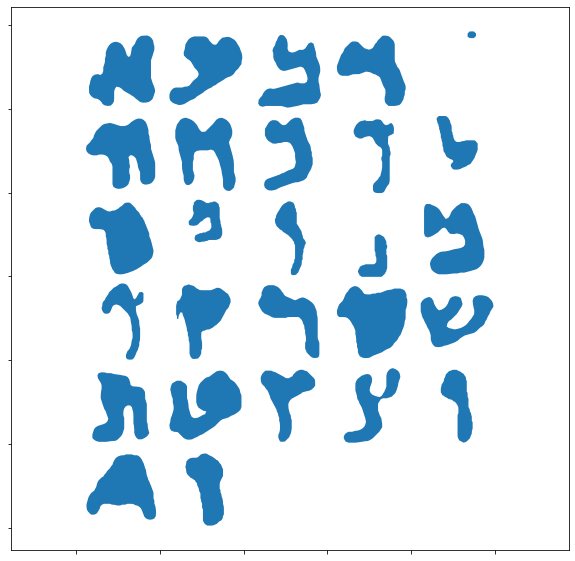

In [460]:
allographs = load_allographs(max_examples=1)
allo_comp = select_largest_component(allographs)
contours = get_contours(allo_comp)
labels, features = make_contour_features(contours)
plot_median_contours(labels, features)
ax = plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.savefig('contour_examples.png')

In [286]:
features.shape

(270, 200)

In [292]:
test_alef = np.mean(features[labels == "Alef"], axis=0).reshape(2,-1)

In [295]:
test_shin = np.mean(features[labels == "Shin"], axis=0).reshape(2,-1)

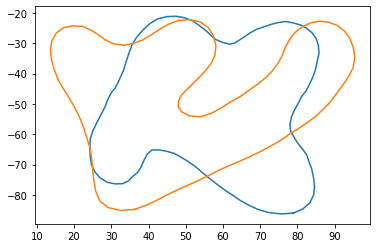

In [299]:
plt.plot(test_shin[1], -test_shin[0])

In [335]:
def plot_median_contour(features, labels, name, pos_x = 0, pos_y = 0, color=None):
    examples = features[labels == name]
    if len(examples) > 0:
        contour = np.median(examples, axis=0).reshape(2,-1)
        plt.fill(contour[1] + 100*pos_x, -contour[0] - 100 * pos_y, lw=0.5, color=color)
def plot_median_contours(labels, features):
    plt.figure(figsize=(10, 10))
    for n, l in enumerate(np.unique(labels)):
        pos_x = n % 5
        pos_y = n // 5
        plot_median_contour(features, labels, l, pos_x, pos_y)
    plt.axis('equal')
def compare_median_contours(labels_a, features_a, labels_b, features_b):
    plt.figure(figsize=(20, 10))
    for n, l in enumerate(np.unique(labels_a)):
        pos_x = n % 5
        pos_y = (n // 5) * 2
        plot_median_contour(features_a, labels_a, l, pos_x, pos_y, color='red')
    for n, l in enumerate(np.unique(labels_b)):
        pos_x = n % 5
        pos_y = (n // 5) * 2 + 1
        plot_median_contour(features_b, labels_b, l, pos_x, pos_y, color='blue')
    plt.axis('equal')

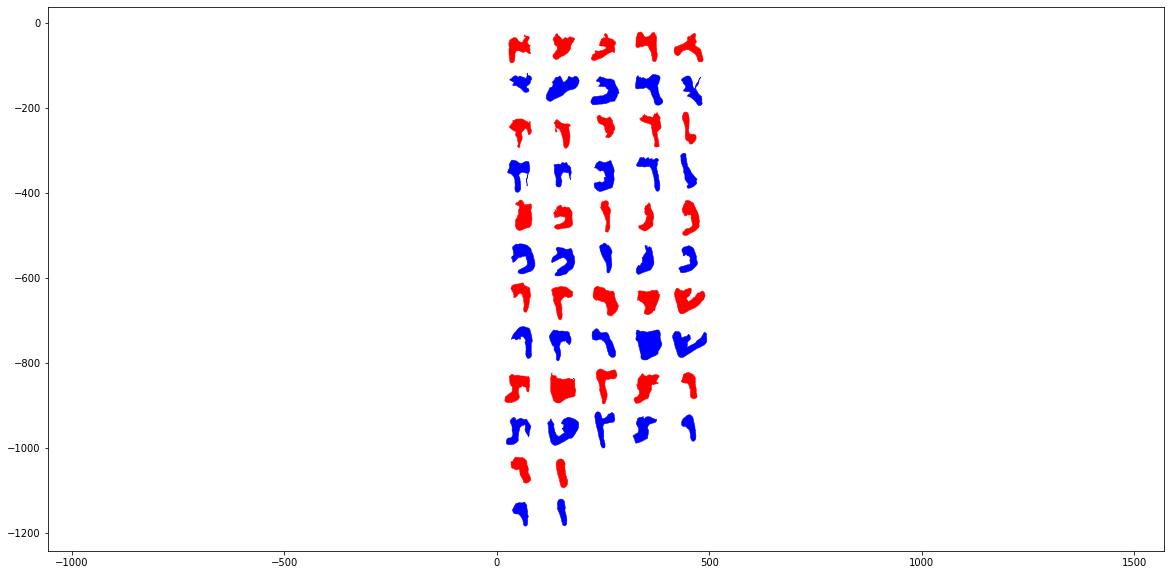

In [345]:
allographs = load_allographs(path = "../../style/Hasmonean", max_examples = 10)
allo_comp = select_largest_component(allographs)
contours = get_contours(allo_comp)
labels_has, features_has = make_contour_features(contours)

allographs = load_allographs(path = "../../style/Herodian", max_examples = 10)
allo_comp = select_largest_component(allographs)
contours = get_contours(allo_comp)
labels_her, features_her = make_contour_features(contours)

compare_median_contours(labels_has, features_has, labels_her, features_her)


 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 96.10043399056453


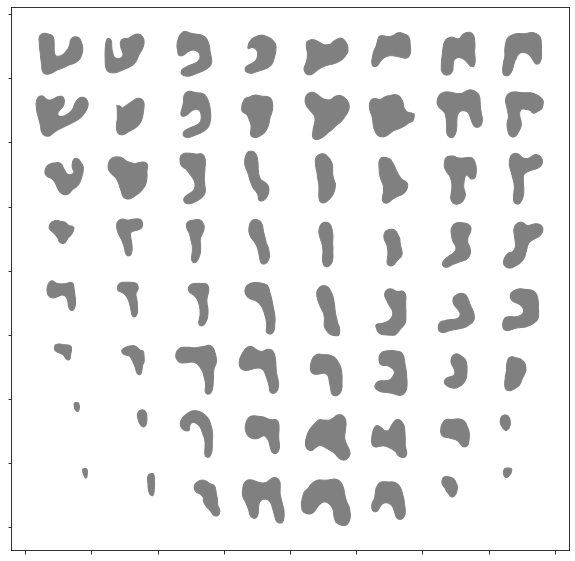

In [461]:
from minisom import MiniSom
from sklearn.preprocessing import scale

allographs = load_allographs(path = "../../style/Hasmonean")
allo_comp = select_largest_component(allographs)
contours = get_contours(allo_comp)
labels_has, features_has = make_contour_features(contours)
data = features_has

som = MiniSom(8, 8, 200, sigma=1.0, learning_rate=0.1)
som.random_weights_init(data)
som.train(data, 10000, verbose=True, random_order=True)
plot_som_neurons(som)

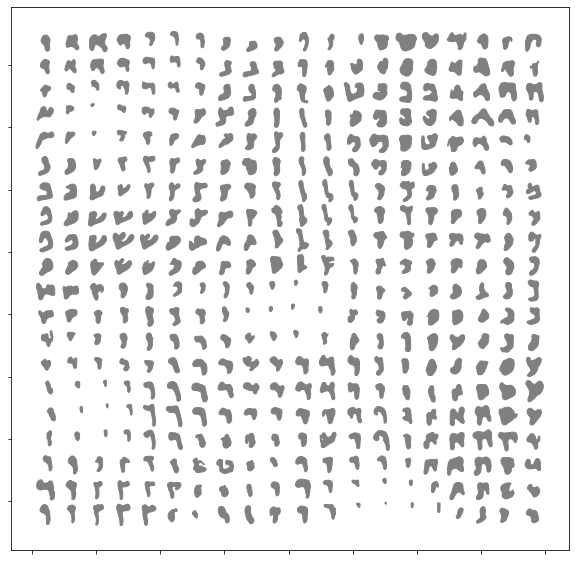

In [449]:
plot_som_neurons(som)
plt.savefig("som_test_20x20.png")

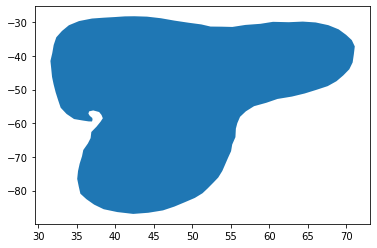

In [423]:
test = som.get_weights()[4,3].reshape(2,-1)
plt.fill(test[1], -test[0])

In [446]:
def plot_som_neurons(som):
    """ Plot outcome of the SOM
    """
    weights = som.get_weights()
    dim = weights.shape[2] // 2
    plt.figure(figsize=(10,10))
    for i, j in np.ndindex(weights.shape[:2]):
        y = -weights[i,j, :dim]
        x = weights[i,j, dim:]
        plt.fill(100 * i + x, 100 * j + y, color='gray')
    ax = plt.gca()
    ax.set_yticklabels([])
    ax.set_xticklabels([])

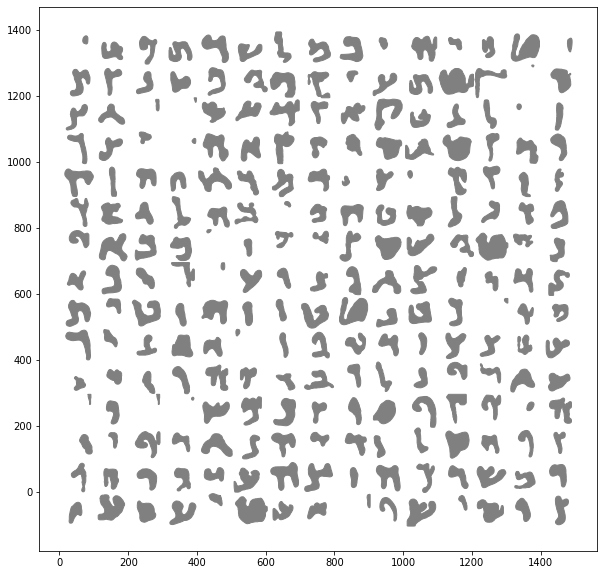

In [437]:
plot_som_neurons(som)

In [428]:
som.get_weights().shape

(15, 15, 200)

In [234]:
contour = find_contours(components['Shin'][3], 0.5)[0]

# Interpolate the contour

# Contours are already starting at the bottom and clockwise. That is good enough for now. 
x = contour[:,0]
y = contour[:,1]

N = 100

x_interp = np.interp(
    np.linspace(0, 1, N, endpoint=True),
    np.linspace(0, 1, len(x), endpoint=True), 
    x)
y_interp = np.interp(
    np.linspace(0, 1, N, endpoint=True),
    np.linspace(0, 1, len(y), endpoint=True), 
    y)


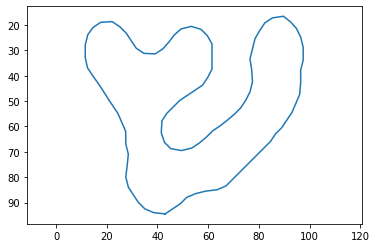

In [235]:
fig = plt.figure()
plt.axis('equal')
plt.gca().invert_yaxis()
plt.plot(y_interp, x_interp)

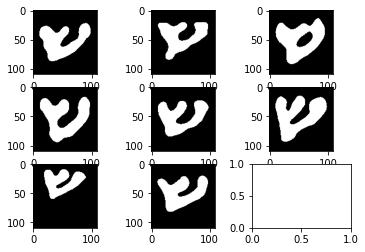

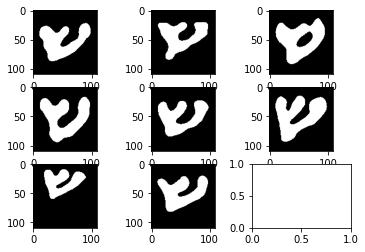

In [178]:
allographs = load_allographs(max_examples = 8)
components = select_largest_component(allographs)
io.imshow_collection(components['Shin'], cmap='gray')

In [165]:
range(10)[:4]

range(0, 4)

In [153]:
import sklearn.datasets
datasets = sklearn.datasets.load_sample_images()

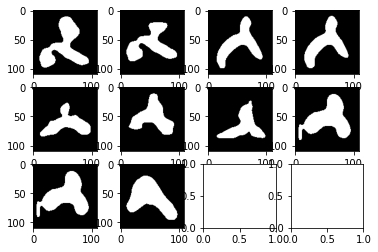

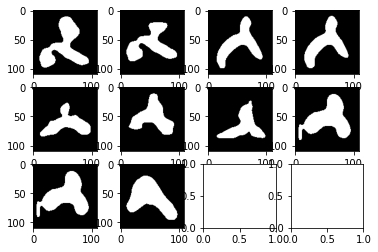

In [154]:
allographs = load_allographs(max_examples = 10)
select_largest_component(allographs)
io.imshow_collection([label(im) for im in allographs['Gimel'][:10]], cmap='gray')

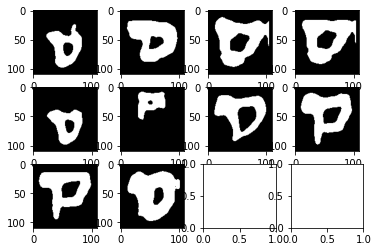

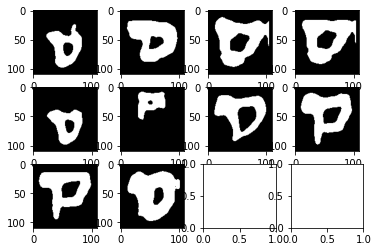

In [160]:
io.imshow_collection([label(im) for im in allographs['Samekh'][:10]], cmap='gray')

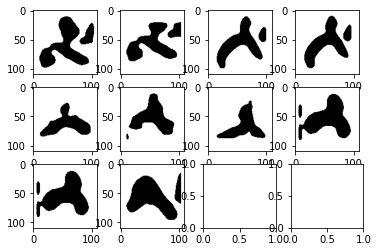

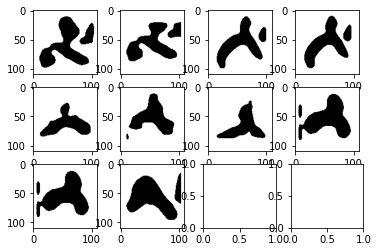

In [145]:
io.imshow_collection([label(im) for im in allographs['Gimel'][:10]], cmap='gray')

In [146]:
label(allographs['Gimel'][0])

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)

In [75]:
alef = data['Alef'].concatenate()

In [134]:
[a for a in allographs.values()]

[array([[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]],
 
        [[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]],
 
        [[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True, 

In [125]:
import skimage.morphology as morphology
from skimage.util import apply_parallel
data = load_contours()
alef = data['Alef'].concatenate()
for i in range(alef.shape[0]):
    alef[i] = morphology.dilation(alef[i], morphology.disk(3))
#closed = apply_parallel(morphology.closing, alef, extra_arguments={'morphology.disk(3)'})

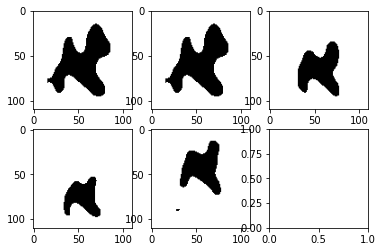

In [126]:
io.imshow_collection(alef[:5], cmap='gray')
pass